# Problem : Extract numbers from string

In [1]:
import re

In [2]:
myStr = """{"orders":[{"id":1},{"id":2},{"id":3},{"id":4},{"id":5},{"id":6},{"id":7},{"id":8},{"id":9},{"id":10},{"id":11},{"id":648},{"id":649},{"id":650},{"id":651},{"id":652},{"id":653}],"errors":[{"code":3,"message":"[PHP Warning #2] count(): Parameter must be an array or an object that implements Countable (153)"}]}"""

In [3]:
results = re.findall(":\d+",myStr)
results = [int(x.replace(":","")) for x in results]
results

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 648, 649, 650, 651, 652, 653, 3]

In [4]:
def func_extract_nums(myStr):
    
    results = re.findall(":\d+",myStr)
    results = [int(x.replace(":","")) for x in results]
    return results

In [5]:
func_extract_nums(myStr)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 648, 649, 650, 651, 652, 653, 3]

# Problem : Predict whether the customer will check in or not

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
import warnings
warnings.simplefilter("ignore")

from keras.layers import Dense
from keras.models import Sequential
import tensorflow as tf

In [7]:
train_file_path = "D:\\Data\\Tabular\\Hotel Check In\\train_data_evaluation_part_2.csv"
test_file_path = "D:\\Data\\Tabular\\Hotel Check In\\test_data_evaluation_part2.csv"

In [8]:
# read the data
df = pd.read_csv(train_file_path)
df.shape

(82580, 30)

In [9]:
# check the missing values
df.isna().sum()

Unnamed: 0                 0
ID                         0
Nationality                0
Age                     3746
DaysSinceCreation          0
AverageLeadTime            0
LodgingRevenue             0
OtherRevenue               0
BookingsCanceled           0
BookingsNoShowed           0
BookingsCheckedIn          0
PersonsNights              0
RoomNights                 0
DaysSinceLastStay          0
DaysSinceFirstStay         0
DistributionChannel        0
MarketSegment              0
SRHighFloor                0
SRLowFloor                 0
SRAccessibleRoom           0
SRMediumFloor              0
SRBathtub                  0
SRShower                   0
SRCrib                     0
SRKingSizeBed              0
SRTwinBed                  0
SRNearElevator             0
SRAwayFromElevator         0
SRNoAlcoholInMiniBar       0
SRQuietRoom                0
dtype: int64

In [10]:
df["BookingsCanceled"] = np.where(df["BookingsCanceled"]>0,1,0)
df['BookingsCheckedIn'] = np.where(df['BookingsCheckedIn']>0,True,False)

In [11]:
df_can_df = df.loc[df.BookingsCanceled==1].groupby(["Nationality"]\
                                                  ).aggregate(\
                                                    num_cancels=("BookingsCanceled","count")).reset_index()
df_can_df = df_can_df.sort_values(by="num_cancels",ascending=False)

df_non_can_df = df.loc[df.BookingsCanceled==0].groupby(["Nationality"]\
                                                  ).aggregate(\
                                                    num_non_cancels=("BookingsCanceled","count")).reset_index()
df_non_can_df = df_non_can_df.sort_values(by="num_non_cancels",ascending=False)

df_bookings = pd.merge(df_can_df,df_non_can_df,on='Nationality',how='inner')
df_bookings['cancellation_percentage'] = 100*round(df_bookings['num_cancels']/\
                                                (df_bookings['num_cancels']+df_bookings['num_non_cancels']),2)
df_bookings = df_bookings.sort_values("cancellation_percentage",ascending=False)

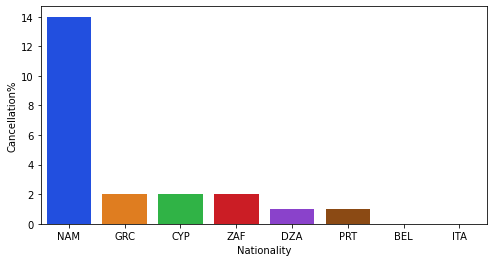

In [12]:
plt.figure(figsize=(8,4))
sns.barplot(x="Nationality",y="cancellation_percentage",data=df_bookings.head(8),palette="bright")
plt.xlabel("Nationality")
plt.ylabel("Cancellation%");

In [13]:
# One of the features can be if the Nationality is in ["NAM","GRC","CYP","ZAP","DZA","PRT"], rest all
# can be tagged as others

In [14]:
Nationality_Concern = ["NAM","GRC","CYP","ZAP","DZA","PRT"]
df["Nationality"] = np.where(~df["Nationality"].isin(Nationality_Concern),"Others",df["Nationality"])
df["Nationality"].value_counts()

Others    70819
PRT       11382
GRC         238
DZA          77
CYP          57
NAM           7
Name: Nationality, dtype: int64

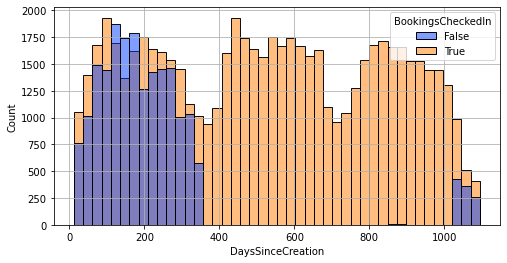

In [15]:
# Higher since the day of creation, higher the probability of check in
plt.figure(figsize=(8,4))
sns.histplot(data = df,x="DaysSinceCreation",hue="BookingsCheckedIn",palette="bright")
plt.grid(True);

In [16]:
df['AverageLeadTime'].describe()

count    82580.000000
mean        66.557205
std         87.928995
min         -1.000000
25%          0.000000
50%         30.000000
75%        104.000000
max        588.000000
Name: AverageLeadTime, dtype: float64

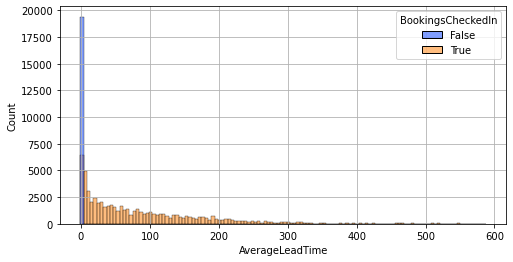

In [17]:
# If the average lead time is close to zero, then higher the probability of not checking in.
# But lead time cannot be negative. Hence those data needs to be removed.

plt.figure(figsize=(8,4))
sns.histplot(data = df,x="AverageLeadTime",hue="BookingsCheckedIn",palette="bright")
plt.grid(True);

In [18]:
# removing records where customer hasn't arrived yet after booking,nor has cancelled the booking.
df = df.loc[df.AverageLeadTime>=0]
df.shape

(82570, 30)

In [19]:
df["AverageLeadTime"] = np.where(df["AverageLeadTime"]>0,"Likely","NotLikely")
df["AverageLeadTime"].value_counts()

Likely       60413
NotLikely    22157
Name: AverageLeadTime, dtype: int64

In [20]:
df['LodgingRevenue'].describe()

count    82570.000000
mean       300.472559
std        373.356022
min          0.000000
25%         66.327500
50%        234.000000
75%        403.915000
max      21781.000000
Name: LodgingRevenue, dtype: float64

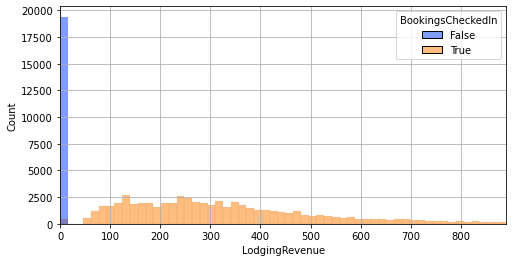

In [21]:
# loding revenue greater than 0 previously, then there is a high chance of check in. 
plt.figure(figsize=(8,4))
sns.histplot(data = df,x="LodgingRevenue",hue="BookingsCheckedIn",palette="bright")
plt.xlim(0,np.quantile(df["LodgingRevenue"],0.95))
plt.grid(True);

In [22]:
max_lim = np.quantile(df["LodgingRevenue"],0.95)
df["LodgingRevenue"] = np.where(df["LodgingRevenue"]>max_lim,max_lim,df["LodgingRevenue"])

In [23]:
df['OtherRevenue'].describe()

count    82570.000000
mean        67.897385
std        114.501149
min          0.000000
25%          2.000000
50%         39.000000
75%         88.000000
max       7730.250000
Name: OtherRevenue, dtype: float64

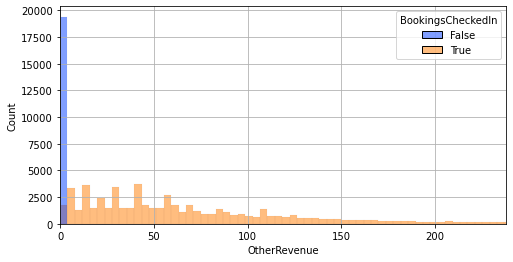

In [24]:
plt.figure(figsize=(8,4))
sns.histplot(data = df,x="OtherRevenue",hue="BookingsCheckedIn",palette="bright")
plt.xlim(0,np.quantile(df["OtherRevenue"],0.95))
plt.grid(True);

In [25]:
# similarly for other rev
max_lim = np.quantile(df["OtherRevenue"],0.95)
df["OtherRevenue"] = np.where(df["OtherRevenue"]>max_lim,max_lim,df["OtherRevenue"])

In [26]:
df[["RoomNights","PersonsNights"]].describe()

,RoomNights,PersonsNights
count,82570.000000,82570.000000
mean,2.369577,4.668245
std,2.281846,4.562704
min,0.000000,0.000000
25%,1.000000,1.000000
50%,2.000000,4.000000
75%,4.000000,7.000000
max,185.000000,116.000000


In [27]:
# similarly for other variables
max_lim = np.quantile(df["RoomNights"],0.95)
df["RoomNights"] = np.where(df["RoomNights"]>max_lim,max_lim,df["RoomNights"])

max_lim = np.quantile(df["PersonsNights"],0.95)
df["PersonsNights"] = np.where(df["PersonsNights"]>max_lim,max_lim,df["PersonsNights"])

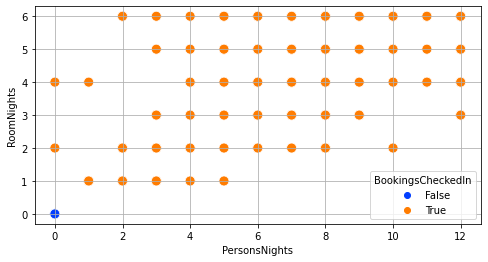

In [28]:
# Very high probability of check in if person nights previously is >0
plt.figure(figsize=(8,4))
sns.scatterplot(data=df,x="PersonsNights",y="RoomNights",hue="BookingsCheckedIn",s=100,palette="bright")
plt.grid(True);

In [29]:
df_can_df = df.loc[df.BookingsCanceled==1].groupby(["DistributionChannel"]\
                                                  ).aggregate(\
                                                    num_cancels=("BookingsCanceled","count")).reset_index()
df_can_df = df_can_df.sort_values(by="num_cancels",ascending=False)

df_non_can_df = df.loc[df.BookingsCanceled==0].groupby(["DistributionChannel"]\
                                                  ).aggregate(\
                                                    num_non_cancels=("BookingsCanceled","count")).reset_index()
df_non_can_df = df_non_can_df.sort_values(by="num_non_cancels",ascending=False)

df_bookings = pd.merge(df_can_df,df_non_can_df,on='DistributionChannel',how='inner')
df_bookings['cancellation_percentage'] = 100*round(df_bookings['num_cancels']/\
                                                (df_bookings['num_cancels']+df_bookings['num_non_cancels']),2)
df_bookings = df_bookings.sort_values("cancellation_percentage",ascending=False)

In [30]:
df_bookings

,DistributionChannel,num_cancels,num_non_cancels,cancellation_percentage
0,Corporate,80,2485,3.0
1,Direct,28,11681,0.0
2,Travel Agent/Operator,10,67778,0.0


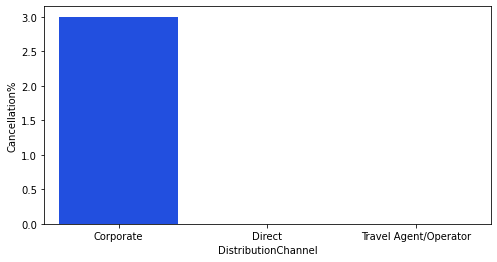

In [31]:
# Usually corporate channel have highest cancellation %
plt.figure(figsize=(8,4))
sns.barplot(x="DistributionChannel",y="cancellation_percentage",data=df_bookings,palette="bright")
plt.xlabel("DistributionChannel")
plt.ylabel("Cancellation%");

In [32]:
df["DistributionChannel"] = np.where(df["DistributionChannel"]=="Corporate","Corporate","Non Corporate")
df["DistributionChannel"].value_counts()

Non Corporate    80005
Corporate         2565
Name: DistributionChannel, dtype: int64

In [33]:
df_can_df = df.loc[df.BookingsCanceled==1].groupby(["MarketSegment"]\
                                                  ).aggregate(\
                                                    num_cancels=("BookingsCanceled","count")).reset_index()
df_can_df = df_can_df.sort_values(by="num_cancels",ascending=False)

df_non_can_df = df.loc[df.BookingsCanceled==0].groupby(["MarketSegment"]\
                                                  ).aggregate(\
                                                    num_non_cancels=("BookingsCanceled","count")).reset_index()
df_non_can_df = df_non_can_df.sort_values(by="num_non_cancels",ascending=False)

df_bookings = pd.merge(df_can_df,df_non_can_df,on='MarketSegment',how='inner')
df_bookings['cancellation_percentage'] = 100*round(df_bookings['num_cancels']/\
                                                (df_bookings['num_cancels']+df_bookings['num_non_cancels']),2)
df_bookings = df_bookings.sort_values("cancellation_percentage",ascending=False)

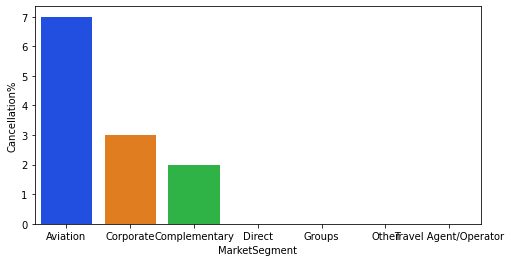

In [34]:
# Usually corporate channel have highest cancellation %
plt.figure(figsize=(8,4))
sns.barplot(x="MarketSegment",y="cancellation_percentage",data=df_bookings,palette="bright")
plt.xlabel("MarketSegment")
plt.ylabel("Cancellation%");

In [35]:
df.MarketSegment.value_counts()

Other                    47447
Travel Agent/Operator    11482
Direct                   11278
Groups                    9501
Corporate                 2135
Complementary              484
Aviation                   243
Name: MarketSegment, dtype: int64

In [36]:
Market_Segment_Concern = ["Aviation","Complementary","Corporate"]
df["MarketSegment"] = np.where(~df["MarketSegment"].isin(Market_Segment_Concern),"Others",df["MarketSegment"])
df["MarketSegment"].value_counts()

Others           79708
Corporate         2135
Complementary      484
Aviation           243
Name: MarketSegment, dtype: int64

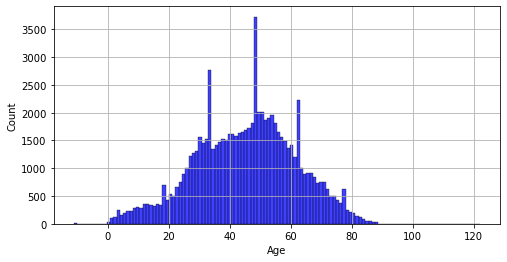

In [37]:
plt.figure(figsize=(8,4))
sns.histplot(df["Age"],color="blue")
plt.grid(True);

In [38]:
# Age cannot be 0. Values that are lower than quantile 0.05 and greater than 0.95 are capped.

max_val_lim_feat = df["Age"].quantile(0.95)
min_val_lim_feat = df["Age"].quantile(0.05)

df["Age"] = np.where(df["Age"]>max_val_lim_feat,max_val_lim_feat,df["Age"])
df["Age"] = np.where(df["Age"]<min_val_lim_feat,min_val_lim_feat,df["Age"])
df["Age"] = np.where(df.Age.isna(),df.Age.median(),df.Age)

In [39]:
df.drop(["Unnamed: 0","BookingsNoShowed","BookingsCanceled"],axis=1,inplace=True)

In [40]:
# segregate feature columns and non feature columns.
TARGET = "BookingsCheckedIn"
ID_COLUMN = "ID"

non_feat_cols = [ID_COLUMN,TARGET]
feat_cols = [x for x in df.columns if x not in non_feat_cols]
cat_cols = [x for x in feat_cols if df[x].dtype=='O']

In [41]:
cat_cols

['Nationality', 'AverageLeadTime', 'DistributionChannel', 'MarketSegment']

In [42]:
df_temp = pd.get_dummies(df[cat_cols],drop_first=True)
df.drop(cat_cols,axis=1,inplace=True)

In [43]:
one_hot_encoded_cat_cols = df_temp.columns.tolist()
one_hot_encoded_cat_cols

['Nationality_DZA',
 'Nationality_GRC',
 'Nationality_NAM',
 'Nationality_Others',
 'Nationality_PRT',
 'AverageLeadTime_NotLikely',
 'DistributionChannel_Non Corporate',
 'MarketSegment_Complementary',
 'MarketSegment_Corporate',
 'MarketSegment_Others']

In [44]:
df[one_hot_encoded_cat_cols] = df_temp[one_hot_encoded_cat_cols].values.tolist()

In [45]:
feat_cols_considered = [x for x in df.columns if x not in non_feat_cols]

In [46]:
X = df[feat_cols_considered]
y = df[TARGET]

# split the X and y into training and validation data
x_train,x_val,y_train,y_val = train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)

In [47]:
# Rf is by default low bias and low variance model, hence can be used to get initial guess on 
# feature importance and model performance
clf = RandomForestClassifier(random_state=42,class_weight='balanced')
clf.fit(x_train,y_train)
feat_imp_thr = np.quantile(clf.feature_importances_,0.75)
# chosing features which have feature importance
feats_selec = np.array(feat_cols_considered)[np.where(clf.feature_importances_>feat_imp_thr)].tolist()

In [48]:
len(feats_selec),len(feat_cols_considered)

(8, 31)

In [49]:
feats_selec

['DaysSinceCreation',
 'LodgingRevenue',
 'OtherRevenue',
 'PersonsNights',
 'RoomNights',
 'DaysSinceLastStay',
 'DaysSinceFirstStay',
 'AverageLeadTime_NotLikely']

In [50]:
scaler = MinMaxScaler()
scaler.fit(X[feats_selec])

MinMaxScaler()

In [51]:
X_scaled = scaler.transform(X[feats_selec])
X_scaled = pd.DataFrame(X_scaled,columns=feats_selec)

In [52]:
# split the X and y into training and testing data
x_train,x_val,y_train,y_val = train_test_split(X_scaled[feats_selec],y,
                                                 test_size=0.25,stratify=y,random_state=42)

In [53]:
from keras.callbacks import EarlyStopping

In [54]:
optimizer_ = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [55]:
model  = Sequential()
model.add(Dense(100, activation = 'relu',input_shape = (x_train.shape[1],)))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(optimizer = optimizer_, loss = 'binary_crossentropy', metrics = ['accuracy'])
model_history = model.fit(x_train, y_train, 
                          validation_data = (x_val, y_val),epochs = 30)

CallBack = EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=10)

Epoch 1/30
1936/1936 [==============================] - 2s 766us/step - loss: 0.2040 - accuracy: 0.9781 - val_loss: 0.0439 - val_accuracy: 0.9936
Epoch 2/30
1936/1936 [==============================] - 1s 716us/step - loss: 0.0254 - accuracy: 0.9947 - val_loss: 0.0142 - val_accuracy: 0.9967
Epoch 3/30
1936/1936 [==============================] - 1s 699us/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.0066 - val_accuracy: 0.9987
Epoch 4/30
1936/1936 [==============================] - 1s 704us/step - loss: 0.0054 - accuracy: 0.9986 - val_loss: 0.0033 - val_accuracy: 0.9993
Epoch 5/30
1936/1936 [==============================] - 1s 702us/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 6/30
1936/1936 [==============================] - 1s 703us/step - loss: 0.0016 - accuracy: 0.9995 - val_loss: 9.9604e-04 - val_accuracy: 0.9998
Epoch 7/30
1936/1936 [==============================] - 1s 702us/step - loss: 9.6007e-04 - accuracy: 0.9998 - val_loss: 

In [56]:
model_train_loss = model_history.history['loss']
model_val_loss = model_history.history['val_loss']

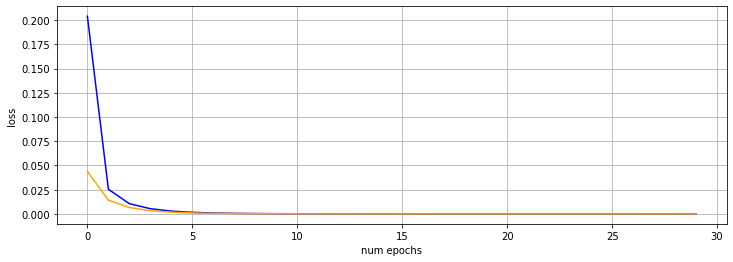

In [57]:
plt.figure(figsize=(12,4))
plt.plot(model_train_loss,color='blue')
plt.plot(model_val_loss,color='orange')
plt.xlabel("num epochs")
plt.ylabel("loss")
plt.grid(True);

In [58]:
joblib.dump(scaler,"scaling_factor")

['scaling_factor']

In [59]:
scaling_factor = joblib.load("scaling_factor")

In [60]:
scaling_factor

MinMaxScaler()

In [61]:
# read the data
df_test = pd.read_csv(test_file_path)
df_test.drop(["Unnamed: 0","BookingsNoShowed","BookingsCanceled"],axis=1,inplace=True)

for feat in ["LodgingRevenue","OtherRevenue","RoomNights","PersonsNights"]:
    max_lim = np.quantile(df[feat],0.95)
    df_test[feat] = np.where(df_test[feat]>max_lim,max_lim,df_test[feat])


df_test["Nationality"] = np.where(~df_test["Nationality"].isin(Nationality_Concern),"Others",\
                                  df_test["Nationality"])

df_test["DistributionChannel"] = np.where(df_test["DistributionChannel"]=="Corporate",
                                          "Corporate","Non Corporate")

df_test["MarketSegment"] = np.where(~df_test["MarketSegment"].isin(Market_Segment_Concern),
                                    "Others",df_test["MarketSegment"])



df_test["AverageLeadTime"] = np.where(df_test["AverageLeadTime"]>0,"Likely","NotLikely")

df_test["Age"] = np.where(df_test["Age"]>max_val_lim_feat,max_val_lim_feat,df_test["Age"])
df_test["Age"] = np.where(df_test["Age"]<min_val_lim_feat,min_val_lim_feat,df_test["Age"])
df_test["Age"] = np.where(df_test.Age.isna(),df.Age.median(),df_test.Age)

df_test['BookingsCheckedIn'] = np.where(df_test['BookingsCheckedIn']>0,True,False)

df_temp_test = pd.get_dummies(df_test[cat_cols])
rem_cat_col = [x for x in one_hot_encoded_cat_cols if x not in df_temp_test.columns]
df_temp_test[rem_cat_col] = 0

df_test.drop(cat_cols,axis=1,inplace=True)
df_test[one_hot_encoded_cat_cols] = df_temp_test[one_hot_encoded_cat_cols].values.tolist()

In [62]:
x_test = df_test[feats_selec]
y_test = df_test[TARGET].values
x_test_scaled = scaling_factor.transform(x_test)

In [63]:
x_test_scaled = pd.DataFrame(x_test_scaled,columns=feats_selec)

In [64]:
y_pred_prob = model.predict(x_test_scaled)
y_pred_prob = [x[0] for x in y_pred_prob]
y_pred = np.where(np.array(y_pred_prob)>0.5,True,False).tolist()

In [65]:
df_report = pd.DataFrame()
df_report['Actual'] = y_test.tolist()
df_report['Prediction'] = y_pred

In [67]:
def get_confusion_matrix(y_test,y_pred,cmap_="Pastel2",title_=None,label_font_size=14):
    
    # Pastel2,Pastel1,gnuplot2,Set3_r -- best
    sns.heatmap(pd.crosstab(y_test,y_pred),annot=True, cmap=cmap_ ,\
            fmt='d',linecolor='white',\
            cbar=False,linewidths=3)
    plt.xlabel("Predicted",fontsize=label_font_size*0.85)
    plt.ylabel("Actual",fontsize=label_font_size*0.85)
    plt.xticks(rotation=45,fontsize=label_font_size)
    plt.yticks(rotation=45,fontsize=label_font_size)
    title_ = "Confusion Matrix" if title_ is None else title_
    plt.title(title_,fontsize=16);

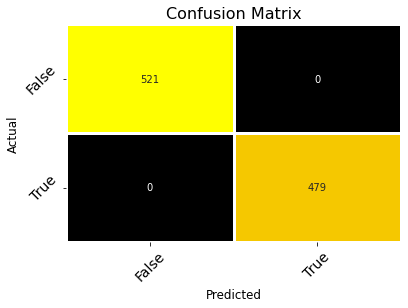

In [68]:
get_confusion_matrix(df_report.Actual,df_report.Prediction,cmap_='gnuplot')

In [69]:
print("Classification report at 0.5 threshold")
print(classification_report(df_report.Actual,df_report.Prediction))

Classification report at 0.5 threshold
              precision    recall  f1-score   support

       False       1.00      1.00      1.00       521
        True       1.00      1.00      1.00       479

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



In [70]:
model.save("ANN_Model.h5")